<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in this assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Key part of this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

In [2]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

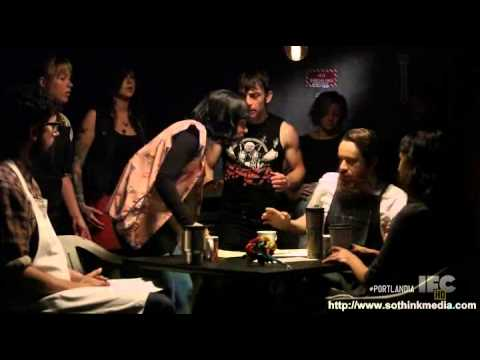

In [3]:
from IPython.display import YouTubeVideo

YouTubeVideo('Jml7NVYm8cs')

In [4]:
%pwd

'/Users/willsn/Desktop/DS-Unit-4-Sprint-1-NLP/module1-text-data'

In [5]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [24]:
# Start here 

## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [6]:
shops.shape

(7616, 3)

In [26]:
#remove "star rating" text from star_rating column

In [7]:
len(shops['star_rating'])

7616

In [8]:
i=0
while i < len(shops['star_rating']):
    shops['star_rating'][i] = shops['star_rating'][i][1]
    #print(shops['star_rating_cleaned'][i])
    #print(shops['star_rating'][i])
    i+=1
    #print(i)

In [29]:
shops

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4
...,...,...,...
7611,The Steeping Room,2/19/2015 I actually step into this restauran...,4
7612,The Steeping Room,"1/21/2016 Ok, The Steeping Room IS awesome. H...",5
7613,The Steeping Room,"4/30/2015 Loved coming here for tea, and the ...",4
7614,The Steeping Room,8/2/2015 The food is just average. The booths...,3


In [30]:
shops['full_review_text'][0]

' 11/25/2016 1 check-in Love love loved the atmosphere! Every corner of the coffee shop had its own style, and there were swings!!! I ordered the matcha latte, and it was muy fantastico! Ordering and getting my drink were pretty streamlined. I ordered on an iPad, which included all beverage selections that ranged from coffee to wine, desired level of sweetness, and a checkout system. I got my latte within minutes!  I was hoping for a typical heart or feather on my latte, but found myself listing out all the possibilities of what the art may be. Any ideas? '

In [31]:
#put the dates in the full_review_text column in a separate column

In [32]:
#get the word cound for full_review_text column

In [33]:
def tokenize(text):
    tokens = re.sub('[^a-zA-Z 0-9]', '', text)
    tokens = tokens.lower().split()
    return tokens

In [34]:
tokenize(shops['full_review_text'][0])

['11252016',
 '1',
 'checkin',
 'love',
 'love',
 'loved',
 'the',
 'atmosphere',
 'every',
 'corner',
 'of',
 'the',
 'coffee',
 'shop',
 'had',
 'its',
 'own',
 'style',
 'and',
 'there',
 'were',
 'swings',
 'i',
 'ordered',
 'the',
 'matcha',
 'latte',
 'and',
 'it',
 'was',
 'muy',
 'fantastico',
 'ordering',
 'and',
 'getting',
 'my',
 'drink',
 'were',
 'pretty',
 'streamlined',
 'i',
 'ordered',
 'on',
 'an',
 'ipad',
 'which',
 'included',
 'all',
 'beverage',
 'selections',
 'that',
 'ranged',
 'from',
 'coffee',
 'to',
 'wine',
 'desired',
 'level',
 'of',
 'sweetness',
 'and',
 'a',
 'checkout',
 'system',
 'i',
 'got',
 'my',
 'latte',
 'within',
 'minutes',
 'i',
 'was',
 'hoping',
 'for',
 'a',
 'typical',
 'heart',
 'or',
 'feather',
 'on',
 'my',
 'latte',
 'but',
 'found',
 'myself',
 'listing',
 'out',
 'all',
 'the',
 'possibilities',
 'of',
 'what',
 'the',
 'art',
 'may',
 'be',
 'any',
 'ideas']

In [35]:
shops['full_review_text'].value_counts(normalize=True)[:50]

 11/22/2016 Cute, eclectic furniture and lots of things to do! Gorgeous seating vignettes, lots of space, classy decor. Only thing to watch out for--no wifi...not really a place to do work or study, but great place to chill! My friends and I (6 of us total) found space to play a board game, and had a blast!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [36]:
'''
i=0
while i < len(shops['full_review_text']):
    shops['full_review_text'][i] = tokenize(shops['full_review_text'][i])
    #print(shops['star_rating'][i])
    i+=1
    #print(i)
'''

"\ni=0\nwhile i < len(shops['full_review_text']):\n    shops['full_review_text'][i] = tokenize(shops['full_review_text'][i])\n    #print(shops['star_rating'][i])\n    i+=1\n    #print(i)\n"

In [39]:
shops['review_tokenized'] = shops['full_review_text'].apply(tokenize)
##This does the same thing as the while loop above, but is much cleaner!

In [41]:
shops['review_tokenized'].head()

0    [11252016, 1, checkin, love, love, loved, the,...
1    [1222016, listed, in, date, night, austin, amb...
2    [11302016, 1, checkin, listed, in, brunch, spo...
3    [11252016, very, cool, decor, good, drinks, ni...
4    [1232016, 1, checkin, they, are, located, with...
Name: review_tokenized, dtype: object

In [ ]:
### Analyzing the tokens

In [42]:
word_counts = Counter()

In [46]:
shops['review_tokenized'].apply(lambda x: word_counts.update(x))

word_counts.most_common(20)

[('the', 104427),
 ('and', 79950),
 ('a', 68265),
 ('i', 60711),
 ('to', 51492),
 ('of', 37800),
 ('is', 35997),
 ('coffee', 31059),
 ('was', 29121),
 ('in', 28638),
 ('it', 28137),
 ('for', 26040),
 ('this', 19749),
 ('but', 19503),
 ('with', 18996),
 ('my', 18606),
 ('they', 18495),
 ('that', 18453),
 ('you', 17541),
 ('place', 16278)]

In [47]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [50]:
wc = count(shops['review_tokenized'])
wc.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
38,the,6847,34809,1.0,0.044537,0.044537,0.899028
52,and,6864,26650,2.0,0.034098,0.078635,0.901261
45,a,6246,22755,3.0,0.029114,0.107749,0.820116
25,i,5528,20237,4.0,0.025893,0.133642,0.725840
64,to,5653,17164,5.0,0.021961,0.155602,0.742253
68,of,5100,12600,6.0,0.016121,0.171724,0.669643
98,is,4999,11999,7.0,0.015352,0.187076,0.656381
67,coffee,4877,10353,8.0,0.013246,0.200322,0.640362
37,was,3765,9707,9.0,0.012420,0.212742,0.494354
100,in,4563,9546,10.0,0.012214,0.224956,0.599133


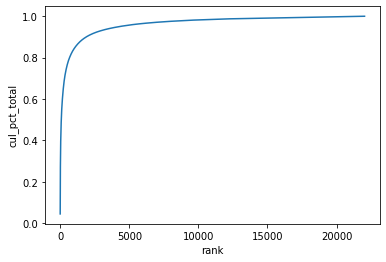

In [51]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [53]:
wc[wc['rank'] <= 100]['cul_pct_total'].max()

## The first 100 words account for 53% of the total.

0.5335194530026511

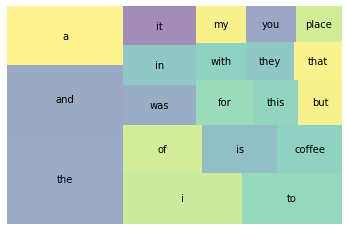

In [55]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.5 )
plt.axis('off')
plt.show()


### Now I'm tokenizing withg Spacey

In [56]:
nlp = spacy.load("en_core_web_lg")

tokenizer = Tokenizer(nlp.vocab)

In [57]:
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [61]:
shops['tokens'].head()

0    [ , 11/25/2016, 1, check-in, Love, love, loved...
1    [ , 12/2/2016, Listed, in, Date, Night:, Austi...
2    [ , 11/30/2016, 1, check-in, Listed, in, Brunc...
3    [ , 11/25/2016, Very, cool, decor!, Good, drin...
4    [ , 12/3/2016, 1, check-in, They, are, located...
Name: tokens, dtype: object

In [64]:
shops['review_tokenized'].head()

###These two columns are the same! Wow Spacey is a lot easier.

0    [11252016, 1, checkin, love, love, loved, the,...
1    [1222016, listed, in, date, night, austin, amb...
2    [11302016, 1, checkin, listed, in, brunch, spo...
3    [11252016, very, cool, decor, good, drinks, ni...
4    [1232016, 1, checkin, they, are, located, with...
Name: review_tokenized, dtype: object

### Adding in stop words

In [66]:
tokens = []

""" Update those tokens w/o stopwords"""
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

shops['tokens'] = tokens

In [68]:
shops['tokens'].head()

0    [ , 11/25/2016, 1, check-in, love, love, loved...
1    [ , 12/2/2016, listed, date, night:, austin,, ...
2    [ , 11/30/2016, 1, check-in, listed, brunch, s...
3    [ , 11/25/2016, cool, decor!, good, drinks, ni...
4    [ , 12/3/2016, 1, check-in, located, northcros...
Name: tokens, dtype: object

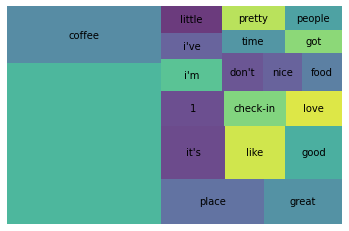

In [70]:
wc = count(shops['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [71]:
wc_top20

#Hmm, the top word is a blank!

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
29,,7616,22606,1.0,0.053592,0.053592,1.000000
41,coffee,4210,8058,2.0,0.019103,0.072695,0.552784
94,place,3029,4264,3.0,0.010109,0.082803,0.397715
157,great,2438,3250,4.0,0.007705,0.090508,0.320116
270,it's,2061,3117,5.0,0.007389,0.097897,0.270614
165,like,2034,2902,6.0,0.006880,0.104777,0.267069
196,good,2084,2779,7.0,0.006588,0.111365,0.273634
3,1,1998,2035,8.0,0.004824,0.116190,0.262342
37,check-in,1957,1961,9.0,0.004649,0.120839,0.256959
34,love,1434,1806,10.0,0.004281,0.125120,0.188288


In [94]:
STOP_WORDS = nlp.Defaults.stop_words.union([' ','1', 'coffee', "i'm", "i've", 'it', "it's", 'it.', 'the', 'this', 'got','-'])

In [95]:
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

In [96]:
wc = count(shops['tokens'])
wc.head(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
90,place,3029,4264,1.0,0.011146,0.011146,0.397715
153,great,2438,3250,2.0,0.008495,0.019642,0.320116
161,like,2034,2902,3.0,0.007586,0.027227,0.267069
192,good,2084,2779,4.0,0.007264,0.034492,0.273634
34,check-in,1957,1961,5.0,0.005126,0.039618,0.256959
31,love,1434,1806,6.0,0.004721,0.044339,0.188288
799,little,1230,1479,7.0,0.003866,0.048205,0.161502
291,don't,1133,1395,8.0,0.003647,0.051851,0.148766
164,nice,1188,1368,9.0,0.003576,0.055427,0.155987
389,food,1092,1363,10.0,0.003563,0.058990,0.143382


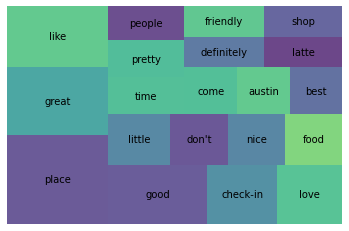

In [97]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

### Now to try some lemmatization


In [107]:
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [113]:
shops['lemmas']=shops['full_review_text'].apply(get_lemmas)

KeyboardInterrupt: 

In [109]:
shops['lemmas'].head()

0    [ , 11/25/2016, 1, check, Love, love, love, at...
1    [ , 12/2/2016, list, Date, Night, Austin, Ambi...
2    [ , 11/30/2016, 1, check, list, Brunch, Spots,...
3    [ , 11/25/2016, cool, decor, good, drink, nice...
4    [ , 12/3/2016, 1, check, locate, Northcross, m...
Name: lemmas, dtype: object

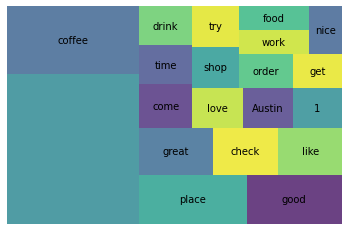

In [110]:
wc = count(shops['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [98]:
shops

,coffee_shop_name,full_review_text,star_rating,review_tokenized,tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,"[11252016, 1, checkin, love, love, loved, the,...","[11/25/2016, check-in, love, love, loved, atmo..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,"[1222016, listed, in, date, night, austin, amb...","[12/2/2016, listed, date, night:, austin,, amb..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,"[11302016, 1, checkin, listed, in, brunch, spo...","[11/30/2016, check-in, listed, brunch, spots, ..."
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,"[11252016, very, cool, decor, good, drinks, ni...","[11/25/2016, cool, decor!, good, drinks, nice,..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4,"[1232016, 1, checkin, they, are, located, with...","[12/3/2016, check-in, located, northcross, mal..."
...,...,...,...,...,...
7611,The Steeping Room,2/19/2015 I actually step into this restauran...,4,"[2192015, i, actually, step, into, this, resta...","[2/19/2015, actually, step, restaurant, chance..."
7612,The Steeping Room,"1/21/2016 Ok, The Steeping Room IS awesome. H...",5,"[1212016, ok, the, steeping, room, is, awesome...","[1/21/2016, ok,, steeping, room, awesome., gre..."
7613,The Steeping Room,"4/30/2015 Loved coming here for tea, and the ...",4,"[4302015, loved, coming, here, for, tea, and, ...","[4/30/2015, loved, coming, tea,, atmosphere, p..."
7614,The Steeping Room,8/2/2015 The food is just average. The booths...,3,"[822015, the, food, is, just, average, the, bo...","[8/2/2015, food, average., booths, didn't, fee..."


In [99]:
shops['star_rating'].value_counts()

5    3780
4    2360
3     738
2     460
1     278
Name: star_rating, dtype: int64

In [100]:
type(shops['star_rating'][0])

numpy.int64

In [101]:
shops['star_rating'] = shops['star_rating'].apply(int)

In [102]:
type(shops['star_rating'][0])

numpy.int64

In [103]:
shops_good = shops[shops['star_rating']>=3]
shops_bad = shops[shops['star_rating']<3]

shops_good.head()

,coffee_shop_name,full_review_text,star_rating,review_tokenized,tokens
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5,"[11252016, 1, checkin, love, love, loved, the,...","[11/25/2016, check-in, love, love, loved, atmo..."
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4,"[1222016, listed, in, date, night, austin, amb...","[12/2/2016, listed, date, night:, austin,, amb..."
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4,"[11302016, 1, checkin, listed, in, brunch, spo...","[11/30/2016, check-in, listed, brunch, spots, ..."
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4,"[1232016, 1, checkin, they, are, located, with...","[12/3/2016, check-in, located, northcross, mal..."
5,The Factory - Cafe With a Soul,11/20/2016 1 check-in Very cute cafe! I think...,4,"[11202016, 1, checkin, very, cute, cafe, i, th...","[11/20/2016, check-in, cute, cafe!, think, mom..."


In [118]:
shops_bad.head()

,coffee_shop_name,full_review_text,star_rating,review_tokenized,tokens
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2,"[11252016, very, cool, decor, good, drinks, ni...","[11/25/2016, cool, decor!, good, drinks, nice,..."
25,The Factory - Cafe With a Soul,"12/2/2016 Okay, so after visiting my friends ...",1,"[1222016, okay, so, after, visiting, my, frien...","[12/2/2016, okay,, visiting, friends, la, tryi..."
39,The Factory - Cafe With a Soul,12/2/2016 A cafe that doesn't have Wifi but m...,1,"[1222016, a, cafe, that, doesnt, have, wifi, b...","[12/2/2016, cafe, doesn't, wifi, makes, order,..."
40,The Factory - Cafe With a Soul,"11/14/2016 Honestly, this place is having an ...",2,"[11142016, honestly, this, place, is, having, ...","[11/14/2016, honestly,, place, having, identit..."
58,The Factory - Cafe With a Soul,11/20/2016 This is a tough one for me. I too...,2,"[11202016, this, is, a, tough, one, for, me, i...","[11/20/2016, tough, me., took, children, treat..."


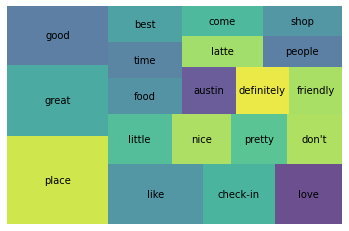

In [119]:
wc = count(shops_good['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## The top 20 words associated with GOOD coffee shops

In [120]:

wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
90,place,2738,3826,1.0,0.011268,0.011268,0.398081
153,great,2321,3100,2.0,0.009130,0.020398,0.337453
298,good,1887,2535,3.0,0.007466,0.027864,0.274353
206,like,1756,2460,4.0,0.007245,0.035109,0.255307
34,check-in,1832,1836,5.0,0.005407,0.040516,0.266356
31,love,1376,1735,6.0,0.005110,0.045626,0.200058
780,little,1154,1387,7.0,0.004085,0.049711,0.167781
211,nice,1112,1282,8.0,0.003776,0.053486,0.161675
32,pretty,954,1214,9.0,0.003575,0.057062,0.138703
262,don't,962,1190,10.0,0.003505,0.060566,0.139866


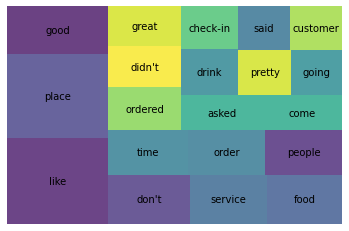

In [121]:
wc = count(shops_bad['tokens'])

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## The top 20 words associated with BAD coffee shops

In [122]:
wc.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
2,like,278,442,1.0,0.010276,0.010276,0.376694
51,place,291,438,2.0,0.010183,0.020460,0.394309
37,good,197,244,3.0,0.005673,0.026133,0.266938
44,don't,171,205,4.0,0.004766,0.030899,0.231707
19,service,151,194,5.0,0.004510,0.035410,0.204607
118,food,119,187,6.0,0.004348,0.039757,0.161247
486,time,134,184,7.0,0.004278,0.044035,0.181572
137,order,116,176,8.0,0.004092,0.048127,0.157182
258,people,134,176,9.0,0.004092,0.052219,0.181572
332,ordered,126,161,10.0,0.003743,0.055962,0.170732


## Some observations about the difference between GOOD and BAD coffee shops

• "place" appears in the top in both. I could probably make that a stop word.

• "great" is the the second most used word in GOOD shops, but doesn't make top ten in BAD coffee shops.

• BAD reviews are more focused on service, food, time, order- all things that probably didn't go well for the customer.

• In contrast, GOOD reviews say things like "nice" and "love" - more focused on emotion and feeling than specific things that happened to the customer. 

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play with the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

